# Market Value Prediction Model
### Notebook where I use machine learning to predict transfer market value of european football/soccer players

### ML Models Used: XGBoost, Neural Networks (Keras)
### Data Science Skills: Permutation Importance, Feature Importance, Shap plots

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import minmax_scaling
import statsmodels.api as sm
import statsmodels.formula.api as smf

import eli5
from eli5.sklearn import PermutationImportance
import shap

from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [75]:
# Import dataset
df = pd.read_csv('Clusters.csv', index_col=0)
df = df.sample(frac=1).reset_index(drop=True)
df

,Player,Position,Team,Comp,Age,MP,Min,Goals,Ast,G+A,...,Interceptions,Clearances,Errors,Dribbles Successful,Dribble Distance,Mistakes,Ball Recoveries,Air Duels Won%,Values,cluster
0,Phil Jagielka,DF,sheffield utd,eng Premier League,37,10,526,0.00,0.00,0.00,...,2.07,8.10,0.34,0.00,26.2,0.00,7.76,60.0,275000.0,Sweeper
1,Mounir Chouiar,FW,dijon,fr Ligue 1,21,23,1288,0.00,0.14,0.14,...,0.63,0.42,0.00,3.36,130.5,2.73,6.36,44.4,6600000.0,False 9
2,Sebastien Corchia,DF,nantes,fr Ligue 1,29,25,2066,0.00,0.04,0.04,...,1.13,3.13,0.00,0.65,73.5,0.70,6.26,49.3,2200000.0,Defensive-Oriented Outside Back
3,Vitinha,MF,wolves,eng Premier League,20,19,520,0.00,0.17,0.17,...,0.69,0.34,0.00,1.38,154.5,1.90,6.21,0.0,7700000.0,Wide Mid
4,Cristian Romero,DF,atalanta,it Serie A,22,31,2545,0.07,0.07,0.14,...,2.86,5.23,0.07,0.35,88.3,0.25,12.70,67.5,33000000.0,Sweeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,Iago,DF,augsburg,de Bundesliga,23,18,1560,0.06,0.06,0.12,...,1.10,3.24,0.00,0.52,106.3,0.81,9.08,40.7,5500000.0,Defensive-Oriented Outside Back
1862,Vagner Goncalves,FW,metz,fr Ligue 1,24,26,967,0.37,0.09,0.47,...,0.37,0.56,0.00,1.31,67.6,4.11,6.45,23.5,3850000.0,False 9
1863,Alexis Trouillet,MF,nice,fr Ligue 1,19,5,109,0.00,0.00,0.00,...,0.83,0.00,0.00,0.83,179.2,2.50,10.00,33.3,2200000.0,Holding Mid
1864,Alex Ferrari,DF,sampdoria,it Serie A,26,12,880,0.00,0.10,0.10,...,1.73,3.47,0.00,0.10,80.8,0.71,8.57,68.0,1980000.0,Sweeper


In [76]:
df.columns

Index(['Player', 'Position', 'Team', 'Comp', 'Age', 'MP', 'Min', 'Goals',
       'Ast', 'G+A', 'xG', 'xA', 'SoT%', 'npxG/Sh', 'G-xG', 'Pass Cmp%',
       'Prog Passes', 'Through Balls', 'Passes Under Pressure',
       'Switch Passes', 'Crosses', 'Shot Creating Actions', 'Dribbles to Shot',
       'Def Action to Shot', 'Tackles', 'Press', 'Shots Blocked',
       'Interceptions', 'Clearances', 'Errors', 'Dribbles Successful',
       'Dribble Distance', 'Mistakes', 'Ball Recoveries', 'Air Duels Won%',
       'Values', 'cluster'],
      dtype='object')

In [77]:
# Drop any columns we will definitely not use for the model
drop_cols = ['Position', 'Team', 'MP']
df.drop(labels=drop_cols, axis=1, inplace=True)
df

,Player,Comp,Age,Min,Goals,Ast,G+A,xG,xA,SoT%,...,Interceptions,Clearances,Errors,Dribbles Successful,Dribble Distance,Mistakes,Ball Recoveries,Air Duels Won%,Values,cluster
0,Phil Jagielka,eng Premier League,37,526,0.00,0.00,0.00,0.00,0.00,30.4,...,2.07,8.10,0.34,0.00,26.2,0.00,7.76,60.0,275000.0,Sweeper
1,Mounir Chouiar,fr Ligue 1,21,1288,0.00,0.14,0.14,0.14,0.14,21.7,...,0.63,0.42,0.00,3.36,130.5,2.73,6.36,44.4,6600000.0,False 9
2,Sebastien Corchia,fr Ligue 1,29,2066,0.00,0.04,0.04,0.03,0.07,33.3,...,1.13,3.13,0.00,0.65,73.5,0.70,6.26,49.3,2200000.0,Defensive-Oriented Outside Back
3,Vitinha,eng Premier League,20,520,0.00,0.17,0.17,0.10,0.12,44.4,...,0.69,0.34,0.00,1.38,154.5,1.90,6.21,0.0,7700000.0,Wide Mid
4,Cristian Romero,it Serie A,22,2545,0.07,0.07,0.14,0.06,0.04,50.0,...,2.86,5.23,0.07,0.35,88.3,0.25,12.70,67.5,33000000.0,Sweeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,Iago,de Bundesliga,23,1560,0.06,0.06,0.12,0.05,0.06,22.2,...,1.10,3.24,0.00,0.52,106.3,0.81,9.08,40.7,5500000.0,Defensive-Oriented Outside Back
1862,Vagner Goncalves,fr Ligue 1,24,967,0.37,0.09,0.47,0.40,0.12,21.1,...,0.37,0.56,0.00,1.31,67.6,4.11,6.45,23.5,3850000.0,False 9
1863,Alexis Trouillet,fr Ligue 1,19,109,0.00,0.00,0.00,0.08,0.33,0.0,...,0.83,0.00,0.00,0.83,179.2,2.50,10.00,33.3,2200000.0,Holding Mid
1864,Alex Ferrari,it Serie A,26,880,0.00,0.10,0.10,0.00,0.04,30.4,...,1.73,3.47,0.00,0.10,80.8,0.71,8.57,68.0,1980000.0,Sweeper


In [78]:
# Label encode categorical variables (Comp, cluster)
label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()
comp_labels = label_encoder_1.fit_transform(df['Comp'])
cluster_labels = label_encoder_2.fit_transform(df['cluster'])
comp_mappings = {index: label for index, label in enumerate(label_encoder_1.classes_)}
cluster_mappings = {index: label for index, label in enumerate(label_encoder_2.classes_)}
print(comp_mappings)
print(cluster_mappings)

{0: 'de Bundesliga', 1: 'eng Premier League', 2: 'es La Liga', 3: 'fr Ligue 1', 4: 'it Serie A'}
{0: 'Advanced Playmaker', 1: 'Ball-Playing Center Back', 2: 'Box-to-Box Mid', 3: 'Defensive-Oriented Outside Back', 4: 'Defensively-Active Forward', 5: 'Do-it-All (Versatile) Backs', 6: 'False 9', 7: 'Goal-Scoring Striker', 8: 'Holding Mid', 9: 'Offensive-Oriented Outside Back', 10: 'Sweeper', 11: 'Wide Mid', 12: 'Wing Forward'}


In [79]:
df.Comp = comp_labels
df.cluster = cluster_labels

In [80]:
# Scale Data for Modeling
scale_cols = ['Age', 'Min', 'Goals', 'Ast', 'G+A', 'xG', 'xA',
       'SoT%', 'npxG/Sh', 'G-xG', 'Pass Cmp%', 'Prog Passes', 'Through Balls',
       'Passes Under Pressure', 'Switch Passes', 'Crosses',
       'Shot Creating Actions', 'Dribbles to Shot', 'Def Action to Shot',
       'Tackles', 'Press', 'Shots Blocked', 'Interceptions', 'Clearances',
       'Errors', 'Dribbles Successful', 'Dribble Distance', 'Mistakes',
       'Ball Recoveries', 'Air Duels Won%']

scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [81]:
df

,Player,Comp,Age,Min,Goals,Ast,G+A,xG,xA,SoT%,...,Interceptions,Clearances,Errors,Dribbles Successful,Dribble Distance,Mistakes,Ball Recoveries,Air Duels Won%,Values,cluster
0,Phil Jagielka,1,0.814815,0.130931,0.000000,0.000000,0.000000,0.000000,0.000000,0.304,...,0.460000,0.609023,0.34,0.000000,0.067630,0.000000,0.393909,0.600,275000.0,10
1,Mounir Chouiar,3,0.222222,0.359760,0.000000,0.153846,0.076923,0.120690,0.241379,0.217,...,0.140000,0.031579,0.00,0.543689,0.336861,0.421947,0.322843,0.444,6600000.0,6
2,Sebastien Corchia,3,0.518519,0.593393,0.000000,0.043956,0.021978,0.025862,0.120690,0.333,...,0.251111,0.235338,0.00,0.105178,0.189726,0.108192,0.317766,0.493,2200000.0,3
3,Vitinha,1,0.185185,0.129129,0.000000,0.186813,0.093407,0.086207,0.206897,0.444,...,0.153333,0.025564,0.00,0.223301,0.398813,0.293663,0.315228,0.000,7700000.0,11
4,Cristian Romero,4,0.259259,0.737237,0.046667,0.076923,0.076923,0.051724,0.068966,0.500,...,0.635556,0.393233,0.07,0.056634,0.227930,0.038640,0.644670,0.675,33000000.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,Iago,0,0.296296,0.441441,0.040000,0.065934,0.065934,0.043103,0.103448,0.222,...,0.244444,0.243609,0.00,0.084142,0.274393,0.125193,0.460914,0.407,5500000.0,3
1862,Vagner Goncalves,3,0.333333,0.263363,0.246667,0.098901,0.258242,0.344828,0.206897,0.211,...,0.082222,0.042105,0.00,0.211974,0.174497,0.635240,0.327411,0.235,3850000.0,6
1863,Alexis Trouillet,3,0.148148,0.005706,0.000000,0.000000,0.000000,0.068966,0.568966,0.000,...,0.184444,0.000000,0.00,0.134304,0.462571,0.386399,0.507614,0.333,2200000.0,8
1864,Alex Ferrari,4,0.407407,0.237237,0.000000,0.109890,0.054945,0.000000,0.068966,0.304,...,0.384444,0.260902,0.00,0.016181,0.208570,0.109737,0.435025,0.680,1980000.0,10


#### Now that we have our dataframe in the right state, we will use Permutation Importance and Partial Dependence Plots to figure out which features to use for our final ML model

#### We will start off with a xgboost model since it is a relatively effective ML model

In [82]:
feature_names = ['Comp', 'Age', 'Min', 'Goals', 'Ast', 'G+A', 'xG', 'xA',
       'SoT%', 'npxG/Sh', 'G-xG', 'Pass Cmp%', 'Prog Passes', 'Through Balls',
       'Passes Under Pressure', 'Switch Passes', 'Crosses',
       'Shot Creating Actions', 'Dribbles to Shot', 'Def Action to Shot',
       'Tackles', 'Press', 'Shots Blocked', 'Interceptions', 'Clearances',
       'Errors', 'Dribbles Successful', 'Dribble Distance', 'Mistakes',
       'Ball Recoveries', 'Air Duels Won%', 'cluster']
X = df[feature_names]
y = df['Values']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

xg_model = XGBRegressor()
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
predictions = xg_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 6712421.617923581


#### Let's see if we can reduce the mean absolute error by finding any features that are not relevant in predicting player values

In [84]:
# Perform Permutation Importance
perm = PermutationImportance(xg_model).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist(), top=35)

Weight,Feature
0.3645 ± 0.0823,Min
0.2222 ± 0.0620,G+A
0.1646 ± 0.0577,Age
0.1439 ± 0.0440,Pass Cmp%
0.0776 ± 0.0414,Comp
0.0421 ± 0.0138,Shot Creating Actions
0.0283 ± 0.0224,Dribble Distance
0.0255 ± 0.0134,xA
0.0196 ± 0.0184,Prog Passes
0.0116 ± 0.0084,Dribbles to Shot


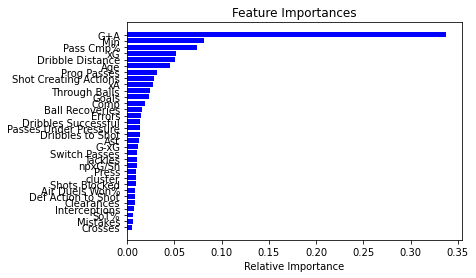

In [85]:
# Perform Feature Importance
importances = xg_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [86]:
# Consider features that have a feature importance score greater than 0.01 as being relevant to the model
important_cols = []
not_important_cols = []
for i in range(len(importances)):
    if importances[i] >= 0.01:
        important_cols.append(features[i])
    else:
        not_important_cols.append(features[i])
        
print("Important Features: ")
for feature in important_cols:
    print(feature)
print("\nNon Important Features: ")
for feature in not_important_cols:
    print(feature)

Important Features: 
Comp
Age
Min
Goals
Ast
G+A
xG
xA
npxG/Sh
G-xG
Pass Cmp%
Prog Passes
Through Balls
Passes Under Pressure
Switch Passes
Shot Creating Actions
Dribbles to Shot
Tackles
Errors
Dribbles Successful
Dribble Distance
Ball Recoveries

Non Important Features: 
SoT%
Crosses
Def Action to Shot
Press
Shots Blocked
Interceptions
Clearances
Mistakes
Air Duels Won%
cluster


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


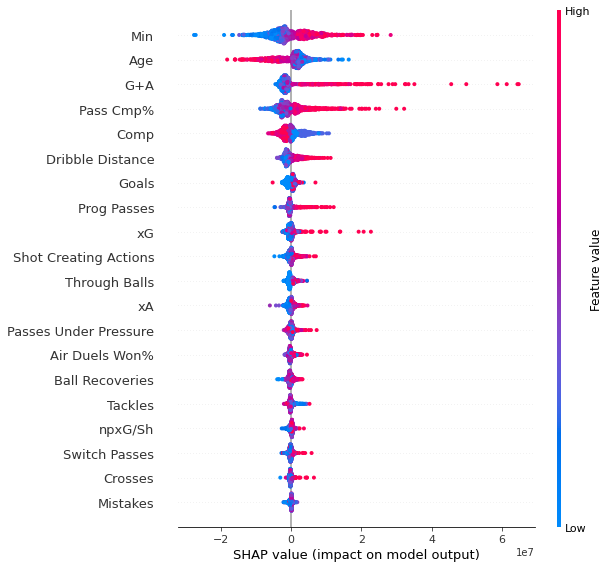

In [87]:
# Use Shap package to explain how each feature effects the market value
shap_values = shap.TreeExplainer(xg_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

#### We will try removing some of the features that seemed less important to the model from the Permutation Importance, Feature Importance, and the Shap plot

In [88]:
X = df[important_cols]
y = df['Values']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

xg_model = XGBRegressor()
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
predictions = xg_model.predict(X_valid)
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 15325212.742229322


#### Since our mean absolute error was worse after elminating some features, we will move on to a neural network model using Keras and see if we can improve our score

In [90]:
def plot_curve(history_df):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    
    history_df.loc[0:, ['loss', 'val_loss']].plot
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max()*1.03])
    plt.show()

In [91]:
df

,Player,Comp,Age,Min,Goals,Ast,G+A,xG,xA,SoT%,...,Interceptions,Clearances,Errors,Dribbles Successful,Dribble Distance,Mistakes,Ball Recoveries,Air Duels Won%,Values,cluster
0,Phil Jagielka,1,0.814815,0.130931,0.000000,0.000000,0.000000,0.000000,0.000000,0.304,...,0.460000,0.609023,0.34,0.000000,0.067630,0.000000,0.393909,0.600,275000.0,10
1,Mounir Chouiar,3,0.222222,0.359760,0.000000,0.153846,0.076923,0.120690,0.241379,0.217,...,0.140000,0.031579,0.00,0.543689,0.336861,0.421947,0.322843,0.444,6600000.0,6
2,Sebastien Corchia,3,0.518519,0.593393,0.000000,0.043956,0.021978,0.025862,0.120690,0.333,...,0.251111,0.235338,0.00,0.105178,0.189726,0.108192,0.317766,0.493,2200000.0,3
3,Vitinha,1,0.185185,0.129129,0.000000,0.186813,0.093407,0.086207,0.206897,0.444,...,0.153333,0.025564,0.00,0.223301,0.398813,0.293663,0.315228,0.000,7700000.0,11
4,Cristian Romero,4,0.259259,0.737237,0.046667,0.076923,0.076923,0.051724,0.068966,0.500,...,0.635556,0.393233,0.07,0.056634,0.227930,0.038640,0.644670,0.675,33000000.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,Iago,0,0.296296,0.441441,0.040000,0.065934,0.065934,0.043103,0.103448,0.222,...,0.244444,0.243609,0.00,0.084142,0.274393,0.125193,0.460914,0.407,5500000.0,3
1862,Vagner Goncalves,3,0.333333,0.263363,0.246667,0.098901,0.258242,0.344828,0.206897,0.211,...,0.082222,0.042105,0.00,0.211974,0.174497,0.635240,0.327411,0.235,3850000.0,6
1863,Alexis Trouillet,3,0.148148,0.005706,0.000000,0.000000,0.000000,0.068966,0.568966,0.000,...,0.184444,0.000000,0.00,0.134304,0.462571,0.386399,0.507614,0.333,2200000.0,8
1864,Alex Ferrari,4,0.407407,0.237237,0.000000,0.109890,0.054945,0.000000,0.068966,0.304,...,0.384444,0.260902,0.00,0.016181,0.208570,0.109737,0.435025,0.680,1980000.0,10


Here is how we'll structure the Neural Network,
Input Layer: Number of features in the training set <br>
32

Hidden Layer: Training Data Samples / (Factors * (Input Neurons + Output Neurons))
1866 / (1 * (33 + 1)) = 54

In [92]:
X = df[feature_names]
y = df['Values']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [93]:
def create_model(optimizer):
    model = keras.Sequential([
        layers.Dense(units=32, activation='relu', input_shape=[32]),
        layers.Dense(units=54, activation='relu'),
        layers.Dense(units=1)
    ])

    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    return model

def train_model(model, X_train, y_train, epochs, batch_size):
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                        batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0)
    
    history_df = pd.DataFrame(history.history)
    
    return history_df

Minimum validation loss: 6880072.5


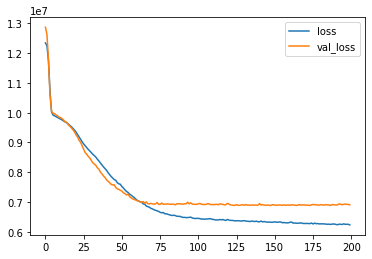

In [98]:
# Assign hyperparameters
early_stopping = callbacks.EarlyStopping(min_delta=100, patience=10, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.05)

learning_rate = 0.03
batch_size = 50
epochs = 200
optimizer = keras.optimizers.Adam(learning_rate=0.05)

my_model = create_model(optimizer)

history_df = train_model(my_model, X_train, y_train, epochs, batch_size)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### Now we will try using only the features that were determined to be "Important" from Permutation and Feature Importance

Minimum validation loss: 6386387.0


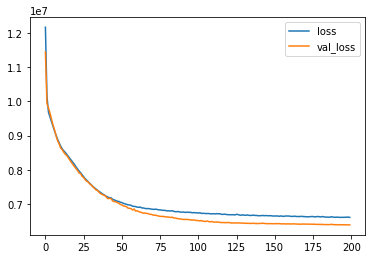

In [99]:
# Neural Network with "Important columns"
X = df[important_cols]
y = df['Values']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

model = keras.Sequential([
        layers.Dense(units=len(important_cols), activation='relu', input_shape=[len(important_cols)]),
        layers.Dense(units=72, activation='relu'),
        layers.Dense(units=1)
    ])

model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

history_df = train_model(model, X_train, y_train, epochs, batch_size)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### The error in fact decreased from reducing the dimensions, so we can now conclude our best ML model to be the Neural Network above with only the "important features" taken from the feature/permutation importance process